In [11]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [15]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [16]:
region = "OCC"

In [17]:
requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [18]:
len(code_bss)

274

## Construction d'un dataframe

In [30]:
directory = '../data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [31]:
data

09654X0569_CNRP20  09892X0679_EXH70  10615X0047_F0  \
date_mesure                                                       
1948-01-01                 NaN               NaN            NaN   
1955-09-06                 NaN               NaN            NaN   
1968-09-13                 NaN               NaN            NaN   
1968-09-14                 NaN               NaN            NaN   
1968-09-15                 NaN               NaN            NaN   
...                        ...               ...            ...   
2022-05-20               -4.46            -27.21            NaN   
2022-05-21               -4.46            -27.21            NaN   
2022-05-22               -4.47            -27.20            NaN   
2022-05-23               -4.47            -27.20            NaN   
2022-05-24               -4.48            -27.21            NaN   

             09648X0083_F90-1  10906X0039_C2-1  10964X0119_NYLS-1  \
date_mesure                                                         
1948-01-01                NaN              NaN                NaN   
1955-09-06                NaN              NaN                NaN   
1968-09-13                NaN              NaN                NaN   
1968-09-14                NaN              NaN                NaN   
1968-09-15                NaN              NaN                NaN   
...                       ...              ...                ...   
2022-05-20                NaN              NaN                NaN   
2022-05-21                NaN              NaN                NaN   
2022-05-22                NaN              NaN                NaN   
2022-05-23                NaN              NaN                NaN   
2022-05-24                NaN              NaN                NaN   

             10602X0001_111111  10398X0063_111111  10383X0025_111111  \
date_mesure                                                            
1948-01-01                 NaN                NaN                NaN   
1955-09-06                 NaN                NaN                NaN   
1968-09-13                 NaN                NaN                NaN   
1968-09-14                 NaN                NaN                NaN   
1968-09-15                 NaN                NaN                NaN   
...                        ...                ...                ...   
2022-05-20                 NaN                NaN              -4.77   
2022-05-21                 NaN                NaN                NaN   
2022-05-22                 NaN                NaN                NaN   
2022-05-23                 NaN                NaN                NaN   
2022-05-24                 NaN                NaN                NaN   

             09645X0035_111111  ...  09645X0025_PEILOU  10405X0135_GUITOU  \
date_mesure                     ...                                         
1948-01-01                 NaN  ...                NaN                NaN   
1955-09-06                 NaN  ...                NaN                NaN   
1968-09-13                 NaN  ...                NaN                NaN   
1968-09-14                 NaN  ...                NaN                NaN   
1968-09-15                 NaN  ...                NaN                NaN   
...                        ...  ...                ...                ...   
2022-05-20                 NaN  ...                NaN                NaN   
2022-05-21                 NaN  ...                NaN                NaN   
2022-05-22                 NaN  ...                NaN                NaN   
2022-05-23                 NaN  ...                NaN                NaN   
2022-05-24                 NaN  ...                NaN                NaN   

             10162X0226_V  10882X0215_ADOUX  09625X0231_LADOUX  08576X0022_HY  \
date_mesure                                                                     
1948-01-01            NaN               NaN                NaN            NaN   
1955-09-06            NaN               NaN                Na

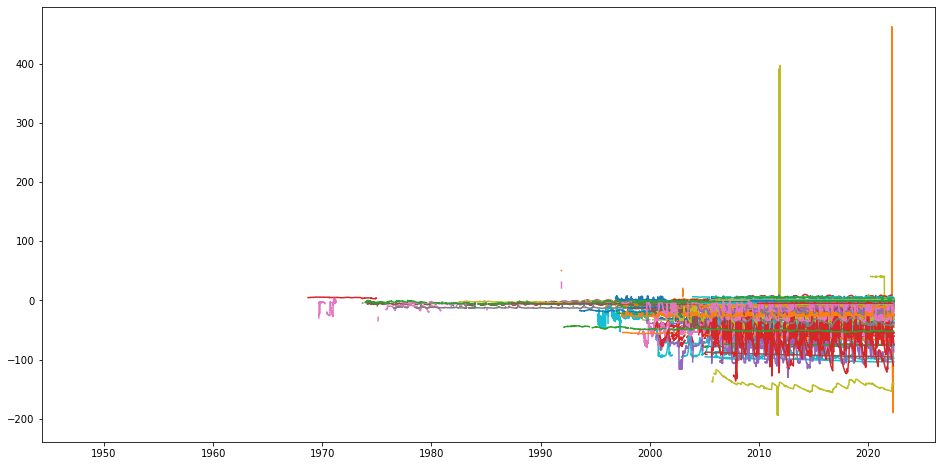

In [32]:
plt.figure(figsize = (16,8))
_=plt.scatter(data)

## Visualisation des valeurs manquantes

In [8]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

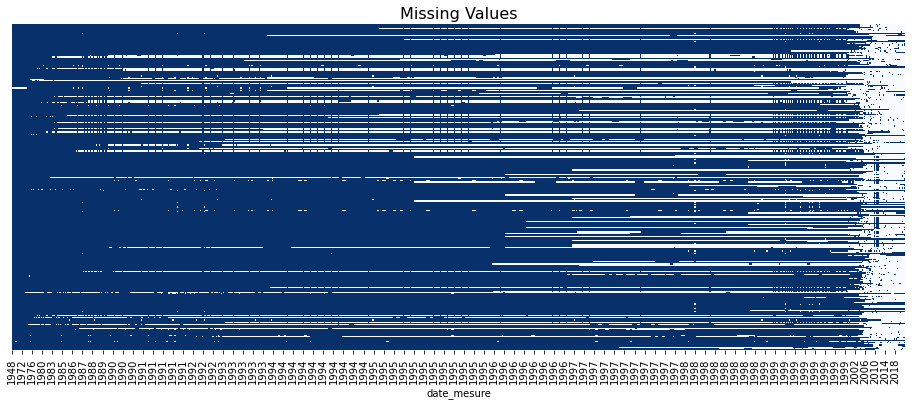

In [9]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [10]:
data_week = pd.DataFrame(data.resample('7D').mean())

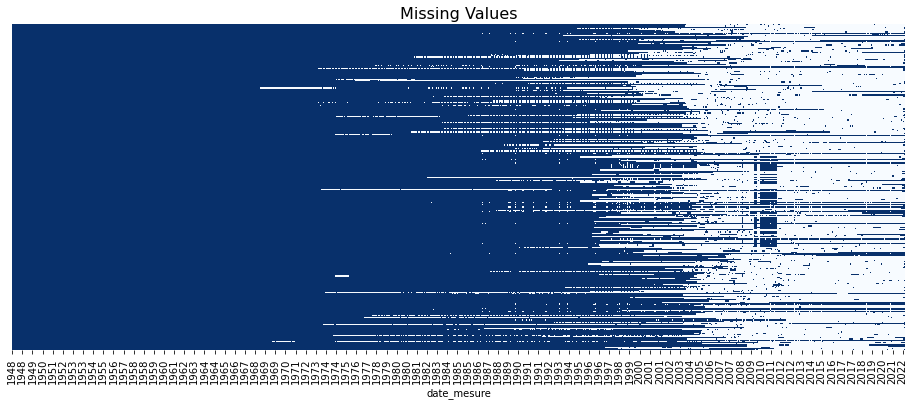

In [11]:
f_plot_nan(data_week)

In [12]:
data_week.shape

(3882, 274)

## Echelle de temps fixée après 2006 pour limiter les Nan

In [14]:
data_week_from_ = data_week.loc['01-01-2006':]

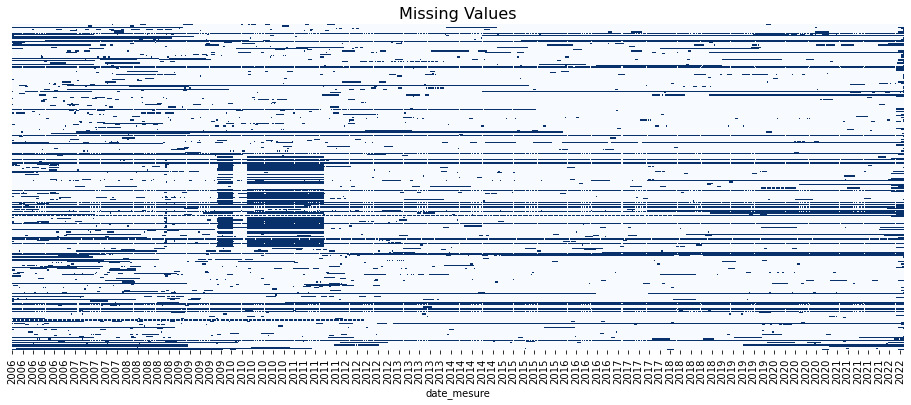

In [15]:
f_plot_nan(data_week_from_)

In [16]:
data_week_from_.shape

(855, 274)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [17]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 43333 valeurs nulles dans l'ensemble du dataframe.


In [18]:
data_wo_outliers = data_week_from_.copy()

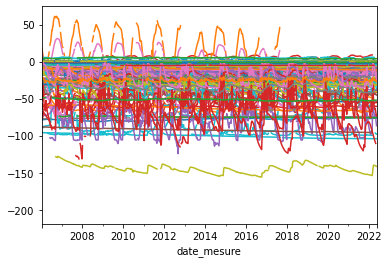

In [19]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

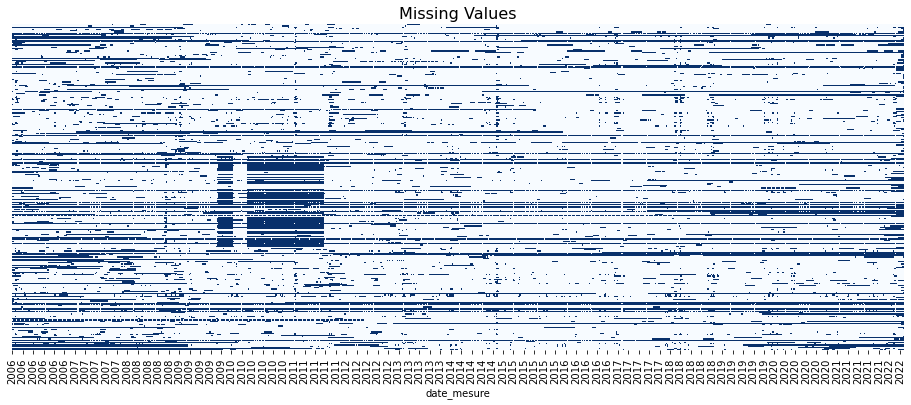

In [20]:
f_plot_nan(data_wo_outliers)

In [21]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 48939 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 10% de valeurs manquantes

In [22]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.10*data_wo_outliers.shape[0]].columns

In [23]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

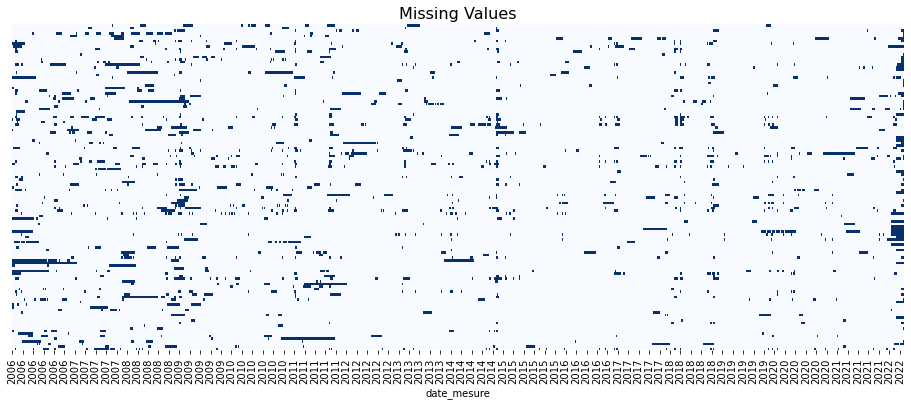

In [24]:
f_plot_nan(data_clean)

In [25]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 4584 valeurs nulles dans l'ensemble du dataframe.


In [26]:
data_clean.shape

(855, 125)

## Interpolation

In [27]:
data_interpol = data_clean.copy().interpolate('linear')

In [28]:
data_interpol.shape

(855, 125)

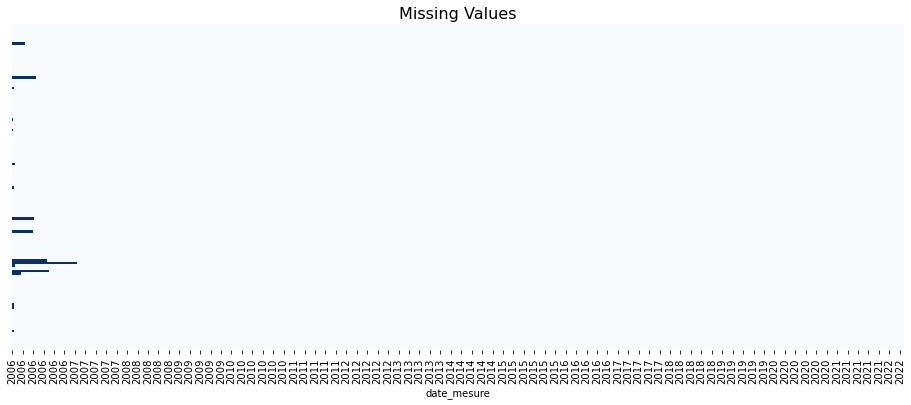

In [29]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [30]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [31]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-19 00:00:00', freq='7D')

In [32]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [33]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [34]:
data_interpol.shape

(792, 125)

In [35]:
data_interpol.shape[1]

125

## Affichage des chroniques après nettoyage

In [36]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

In [37]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [38]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [39]:
data_norm.head()

09654X0569_CNRP20  09892X0679_EXH70  09648X0083_F90-1  \
date_mesure                                                          
2007-03-22           -0.751455         -1.460907         -0.156249   
2007-03-29           -0.028829         -1.440681         -0.194481   
2007-04-05            0.754670         -1.615580         -0.205056   
2007-04-12            1.288785         -1.957049         -0.047249   
2007-04-19            1.453732         -1.869005         -0.144861   

             10906X0039_C2-1  10964X0119_NYLS-1  10602X0001_111111  \
date_mesure                                                          
2007-03-22         -2.570831           1.669811           0.569525   
2007-03-29         -2.653176           1.693311           0.566578   
2007-04-05         -2.740891           1.641276           0.564614   
2007-04-12         -2.825026           1.694989           0.630905   
2007-04-19         -1.813616           1.762131           0.684919   

             09914X0391_V1191  10136X0222_C1  10972X0098_FE1  10163X0157_F1  \
date_mesure                                                                   
2007-03-22           0.140412       0.443765        0.236263      -1.784294   
2007-03-29           0.127664       0.558569        0.333517      -1.784294   
2007-04-05           0.025677       0.153565        0.260576      -1.780754   
2007-04-12           0.076670       1.655590        0.386197      -1.135057   
2007-04-19          -0.008318       0.813690        0.337570      -1.430293   

             ...  09634X0074_CLARET  10972X0137_PONT  09388X0052_VIGNOT  \
date_mesure  ...                                                          
2007-03-22   ...          -0.104236        -0.019297          -0.636868   
2007-03-29   ...          -0.279941         0.065211          -0.683442   
2007-04-05   ...          -0.390020         0.193810          -0.707661   
2007-04-12   ...           0.268271         0.616349          -0.720702   
2007-04-19   ...           0.249434         0.498773          -0.716976   

             10154X0076_MAMERT  09876X0212_PORT  09908X0174_MASJAU  \
date_mesure                                                          
2007-03-22            1.749932        -0.802629           0.177324   
2007-03-29            1.712656        -1.440531           0.171189   
2007-04-05            1.671848        -1.762463           0.166588   
2007-04-12            1.589449        -1.471532           0.172723   
2007-04-19            1.572969        -0.802629           0.171189   

             10963X0059_MEDALU  09645X0025_PEILOU  10162X0226_V  \
date_mesure                                                       
2007-03-22            1.327730          -0.071232     -0.685807   
2007-03-29            1.300028          -0.177262     -0.746213   
2007-04-05            1.272326          -0.306098     -0.802312   
2007-04-12            1.244624          -0.387659      0.764299   
2007-04-19            1.216923          -0.439641      0.634138   

             09625X0231_LADOUX  
date_mesure                     
2007-03-22           -0.945855  
2007-03-29           -0.623221  
2007-04-05           -0.849065  
2007-04-12            0.596335  
2007-04-19           -0.397377  

[5 rows x 125 columns]

## Sauvegarde du dataframe en csv

In [40]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")